# analyse the neural belief and neural eye.

## imports

In [1]:
%reload_ext autoreload
%autoreload 2


In [2]:
import sys
import os
from pathlib import Path
import configparser
config = configparser.ConfigParser()
config.read_file(open('../../privateconfig'))
resdir = Path(config['Datafolder']['data'])
workdir = Path(config['Codefolder']['workspace'])
os.chdir(workdir)

In [3]:
from scipy.io import loadmat
import numpy as np
from datetime import date
from sklearn.decomposition import FastICA



In [4]:
from notification import notify
import matplotlib.pyplot as plt
from pathlib import Path
from scipy.ndimage import gaussian_filter1d
import pickle
import pandas as pd
from plot_ult import *
import warnings
from scipy.stats import pearsonr
from env_config import Config
from firefly_task import ffacc_real
from monkey_functions import *
from InverseFuncs import *
from numpy import pi
from stable_baselines3 import TD3
import torch
import time
from sklearn.datasets import make_regression
from sklearn.model_selection import KFold
from sklearn.linear_model import LassoCV, Lasso
from sklearn.metrics import mean_squared_error
import numpy as np
from neural_plot_ult import *

tic=time.time()
warnings.filterwarnings('ignore')

# Pre IRC

convert the mat data file (with neural data) into (states, actions, tasks) for IRC.


## prepare

In [5]:
# const
bin_size = 17 # how many bin of DT. about 0.1 s
num_bins = 24 # how many bins to use. use 2.4 s and discard the long trials.
monkey_height = 10
DT = 0.006 # DT for raw data
reward_boundary = 65
areas = ['PPC', 'PFC', 'MST']
t_total = 24
fontsize = 7; lw = 1
worldscale =200

m = 'm51'

folder='m51_mat_ruiyi'
dens=[0.0001, 0.0005, 0.001,  0.005]

locals().update({m: {}})
figure_path = resdir/'figures'
# datapaths = [i for i in Path(resdir/'mat_ruiyi').glob(f'{m}*.mat')]
datapaths=[i for i in Path(resdir/folder).glob(f'{m}*.mat')]

datapaths,m

([PosixPath('/home/yc/repo/mkdata/m51_mat_ruiyi/m51s41.mat'),
  PosixPath('/home/yc/repo/mkdata/m51_mat_ruiyi/m51s43.mat'),
  PosixPath('/home/yc/repo/mkdata/m51_mat_ruiyi/m51s42.mat'),
  PosixPath('/home/yc/repo/mkdata/m51_mat_ruiyi/m51s40.mat'),
  PosixPath('/home/yc/repo/mkdata/m51_mat_ruiyi/m51s38.mat')],
 'm51')

## Raw data (same as ruiyi script)

In [6]:
# load raw data
for idx, datapath in enumerate(datapaths):
    if datapath.stem[-1].isalpha():
        continue
    data = loadmat(datapath)
    eval(m)[datapath.stem] = data
    notify(datapath)
    
notify('all done! loaded')

## Neural

In [7]:
m_neural = {}
for key, data in eval(m).items():
    if key[-1].isalpha():
        continue
    trials_behv = data['trials_behv'][0]
    trials_units = data['units'][0]
    
    trials_neural = []
    for trial_idx, trial_behv in enumerate(trials_behv):
        trial_ts = trial_behv['continuous']['ts'][0][0].reshape(-1)

        activities = []
        for trials_unit in trials_units:
            fire_ts = trials_unit['trials'][0][trial_idx][0].reshape(-1)
            if fire_ts.size > 0 and fire_ts[-1] >= trial_ts[-1]:
                fire_ts = fire_ts[:-1]
            activity = np.zeros_like(trial_ts)
            bin_indices = np.digitize(fire_ts, trial_ts)
            unique_bins, bin_counts = np.unique(bin_indices, return_counts=True)
            activity[unique_bins] = bin_counts
            activities.append(activity)

        activities = np.vstack(activities).T   # time * unit
        activities = gaussian_filter1d(activities, sigma=4, axis=0)
        trials_neural.append(activities)    
    m_neural[key + 'neural'] = trials_neural
    
eval(m).update(m_neural)
del m_neural
    
num_bins = 24; bin_size = 17; monkey_height = 10
areas = ['PPC', 'PFC', 'MST']
m_extracted_continuous = {}; m_downsampled = {}; m_errors = {}
for key, data in eval(m).items():
    if key[-1].isalpha():
        continue
        
    trials_behv = data['trials_behv'][0]
    trials_units = data['units'][0]
    units_area = np.array([v[0] for v in trials_units['brain_area']])
    
    Xt = dict(zip(areas, [[[] for _ in range(num_bins)] for area in areas])) 
    Xdownsampled = dict(zip(areas, [[] for area in areas])) 
    
    for trial_idx, trial_behv in enumerate(trials_behv):
        trial_ts = trial_behv['continuous']['ts'][0][0].reshape(-1)
        t_mask = (trial_ts > 0) & (~np.isnan(trial_behv['continuous']['ymp'][0][0].reshape(-1)))
        t_mask &= trial_ts < trial_behv['events']['t_stop'][0][0].reshape(-1)
        if t_mask.sum() > 0:
            t_mask[np.where(t_mask == True)[0][0]] = False # remove the first data point to avoid downsample error

        # for Xt
        activity = eval(m)[key + 'neural'][trial_idx][t_mask]
        activity = downsample(activity, bin_size=bin_size)
        for area in areas:
            area_mask = [v in area for v in units_area]
            if sum(area_mask) == 0:
                continue
            activity_ = activity[:, area_mask]
            Xdownsampled[area].append([trial_idx, activity_])
            for bin_idx in range(num_bins):
                if activity_.shape[0] > bin_idx:
                    Xt[area][bin_idx].append([trial_idx, activity_[bin_idx]])
                    #Xt[area][bin_idx].append([trial_idx, activity_[-(bin_idx+1)]])

    m_downsampled[key + 'Xdownsampled'] = Xdownsampled
    
eval(m).update(m_downsampled)
del m_downsampled


## Task relavent variables (y downsample)

In [8]:
m_extracted_continuous = {}; m_downsampled = {}; m_errors = {}
m_dens={}

for key, data in eval(m).items():
    
    if key[-1].isalpha():
        continue
        
    trials_behv = data['trials_behv'][0]
    trials_units = data['units'][0]
    units_area = np.array([v[0] for v in trials_units['brain_area']])
    Xt = dict(zip(areas, [[[] for _ in range(num_bins)] for area in areas])) 
    Xdownsampled = dict(zip(areas, [[] for area in areas])) 

    Ydownsampled = []
    Y = []
    trials_error = []; trials_error_sign = []; trials_target_angle = []; trials_target_distance = []
    trial_dens=[]
    for trial_idx, trial_behv in enumerate(trials_behv):
        
        # [0.0001 0.0005 0.001  0.005 ]
        # if trial_behv['prs'][0][0]['floordensity'] != density:
        #     continue
        

        trial_ts = trial_behv['continuous']['ts'][0][0].reshape(-1)
        t_mask = (trial_ts > 0) & (~np.isnan(trial_behv['continuous']['ymp'][0][0].reshape(-1)))
        t_mask &= trial_ts < trial_behv['events']['t_stop'][0][0].reshape(-1)
        if t_mask.sum() > 0:
            t_mask[np.where(t_mask == True)[0][0]] = False # remove the first data point to avoid downsample error
        
        # get Y
        mx = trial_behv['continuous']['xmp'][0][0][t_mask]
        my = trial_behv['continuous']['ymp'][0][0][t_mask]
        fx = trial_behv['continuous']['xfp'][0][0][t_mask]
        fy = trial_behv['continuous']['yfp'][0][0][t_mask]
        sx = np.ones_like(fx); sy = np.ones_like(fy)
        if my.size > 0:
            fx = np.ones_like(fx) * fx[0]
            fy = np.ones_like(fy) * fy[0]
            sx *= mx[-1]; sy *= my[-1]
            my = my + 30; fy = fy + 30; sy = sy + 30
        
        dx = fx - mx; dy = fy - my
        rel_dist = np.sqrt(dx**2 + dy**2); rel_ang = np.rad2deg(np.arctan2(dy, dx))
        rel_dist_stop = np.sqrt((sx - mx)**2 + (sy - my)**2)
        
        if my.size > 0:
            trials_error.append(rel_dist[-1][0])
            trials_error_sign.append(rel_dist[-1][0])
            trials_target_angle.append(np.rad2deg(np.arctan2(fy, fx))[-1][0] - 90)
            trials_target_distance.append(np.sqrt(fx**2 + fy**2)[-1][0])
            
        else:
            trials_error.append(np.nan)
            trials_error_sign.append(np.nan)
            trials_target_angle.append(np.nan)
            trials_target_distance.append(np.nan)
        
        if my.size > 0:
            d1 = np.sqrt(fx**2 + fy**2)
            r1 = (fx**2 + fy**2) / (2*fx)
            radian1 = 2 * r1 * np.arcsin(d1 / (2 * r1))

            d2 = np.sqrt(mx**2 + my**2)
            r2 = (mx**2 + my**2) / (2*mx + 1e-8)
            radian2 = 2 * r2 * np.arcsin(d2 / (2 * r2 + 1e-8))

            sign = np.ones_like(rel_dist)
            sign[radian2 < radian1] = -1
            rel_dist = sign * rel_dist
            trials_error_sign[-1] = rel_dist[-1][0]
        
        abs_dist = np.sqrt(mx**2 + my**2); abs_ang = np.rad2deg(np.arctan2(my, mx))

        eye_hor_theta = trial_behv['continuous']['yre'][0][0][t_mask]
        eye_ver_theta = trial_behv['continuous']['zre'][0][0][t_mask]
        # eye_hor_theta = trial_behv['continuous']['yle'][0][0][t_mask] # m51 has no left eye
        # eye_ver_theta = trial_behv['continuous']['zle'][0][0][t_mask]
        mw = -trial_behv['continuous']['w'][0][0][t_mask].reshape(-1)
        body_theta = np.deg2rad(np.cumsum(mw) * DT + 90)
        body_x, body_y = mx.reshape(-1), my.reshape(-1)
        
        latent_ff_hori, latent_ff_vert = convert_location_to_angle(abs(rel_dist).reshape(-1), fx.reshape(-1), fy.reshape(-1),
            body_theta, body_x, body_y, 
            eye_hor_theta.reshape(-1), eye_ver_theta.reshape(-1), remove_pre=False, remove_post=False)

        mv = trial_behv['continuous']['v'][0][0][t_mask].reshape(-1,1)
        mw = trial_behv['continuous']['w'][0][0][t_mask].reshape(-1,1)
        if t_mask.sum() * DT > 3.5 or t_mask.sum() * DT < 0.6 or mv.max() < 50 or \
            abs_dist[-1] < np.sqrt(fx**2 + fy**2)[-1] * 0.3:
            continue
        
        trial_dens.append(trial_behv['prs'][0][0]['floordensity'])
        
        target_variable = np.hstack([rel_dist, rel_ang, abs_dist, abs_ang,
                                     eye_hor_theta, eye_ver_theta, latent_ff_hori, latent_ff_vert,
                                     fx, fy, mx, my, mv, mw])
        Y.append(target_variable)
        target_variable = downsample(target_variable, bin_size=bin_size)
        
        # compute the latent ff in eye cord after downsample, to compare wt belief
        (rel_dist, rel_ang, abs_dist, abs_ang,
                                            eye_hor_theta, eye_ver_theta, latent_ff_hori, latent_ff_vert,
                                            fx, fy, mx, my, mv, mw)=zip(*target_variable)
        body_theta = -np.deg2rad(np.cumsum(mw) * 0.1 -90)
        body_x, body_y = np.array(mx).reshape(-1), np.array(my).reshape(-1)

        latent_ff_hori, latent_ff_vert = convert_location_to_angle(abs(np.array(rel_dist)).reshape(-1), np.array(fx).reshape(-1), np.array(fy).reshape(-1),
            np.array(body_theta), np.array(body_x), np.array(body_y), 
            np.array(eye_hor_theta).reshape(-1), np.array(eye_ver_theta).reshape(-1), remove_pre=False)

        target_variable = np.vstack([rel_dist, rel_ang, abs_dist, abs_ang,
                                     eye_hor_theta, eye_ver_theta, latent_ff_hori.reshape(-1), latent_ff_vert.reshape(-1),
                                     fx, fy, mx, my, mv, mw]).T
        
        # end compute the latent ff with downsampled y
        Ydownsampled.append([trial_idx, target_variable])

        # for Xt
        activity = eval(m)[key + 'neural'][trial_idx][t_mask]
        activity = downsample(activity, bin_size=bin_size)
        for area in areas:
            area_mask = [v in area for v in units_area]
            if sum(area_mask) == 0:
                continue
            activity_ = activity[:, area_mask]
            Xdownsampled[area].append([trial_idx, activity_])
            for bin_idx in range(num_bins):
                if activity_.shape[0] > bin_idx:
                    Xt[area][bin_idx].append([trial_idx, activity_[bin_idx]])
                    #Xt[area][bin_idx].append([trial_idx, activity_[-(bin_idx+1)]])

    m_downsampled[key + 'Xdownsampled'] = Xdownsampled
    m_extracted_continuous[key + 'Y'] = Y
    m_downsampled[key + 'Ydownsampled'] = Ydownsampled
    m_dens[key+'_dens']=trial_dens
    m_errors[key + 'error'] = trials_error; m_errors[key + 'error_sign'] = trials_error_sign
    m_errors[key + 'target_angle'] = trials_target_angle; m_errors[key + 'target_distance'] = trials_target_distance
    
eval(m).update(m_downsampled); eval(m).update(m_extracted_continuous); eval(m).update(m_errors);eval(m).update(m_dens)
# del m_downsampled, m_extracted_continuous, m_errors

In [9]:
# m_downsampled.keys()
Xdownsampled.keys()
# np.array(Xdownsampled['PPC']).shape, np.array(Xdownsampled['PFC']).shape,np.array(Xdownsampled['MST']).shape

trial_idces, yy = zip(*Xdownsampled['PPC'])
# len(trial_idces)
print(np.vstack(yy).shape, len(yy))
trial_idces, yy = zip(*Ydownsampled)
print(np.vstack(yy).shape, len(yy))



(10493, 86) 616
(10493, 14) 616


## IRC input data (state, action, task)

In [10]:
irc_input_data={}

for key, data in eval(m).items():
    if not key.endswith('Ydownsampled'):
        continue
    states, actions, tasks=[],[],[]
    
    print(key)
    y=eval(m)[key]
    trial_idces, yy = zip(*y)

    for itrial in range(len(trial_idces)):
        (rel_dist, rel_ang, abs_dist, abs_ang,
                                     eye_hor_theta, eye_ver_theta, latent_ff_hori, latent_ff_vert,
                                     fx, fy, mx, my, mv, mw)=zip(*yy[itrial])
        # task
        taskx = (fx[0] - mx[0]).astype('float32'); tasky = (fy[0] - my[0]).astype('float32')
        tasks.append([tasky/worldscale,taskx/worldscale])
        # actions
        trialaction=np.stack([mv,mw]).T
        trialaction[:,0]=trialaction[:,0]/worldscale # v need reduce scale
        trialaction[:,1]=trialaction[:,1]/180*pi
        actions.append(trialaction.astype('float32'))

        # states from run the actions
        px, py, heading, v, w = 0,0,0,0,0
        log=[]
        for a in trialaction:
            px, py, heading, v, w=state_step2(px, py, heading, v, w, a, dt=0.1,userad=True)
            log.append([px, py, heading, v, w])
        px, py, heading, v, w=state_step2(px, py, heading, v, w, a, dt=0.1,userad=True)
        log.append([px, py, heading, v, w])
        trialstates=np.array(log)[1:]
        
        states.append(trialstates.astype('float32'))

    irc_input_data[key + '_irc']=(states, actions, tasks)

eval(m).update(irc_input_data)
del irc_input_data


m51s41Ydownsampled
m51s43Ydownsampled
m51s42Ydownsampled
m51s40Ydownsampled
m51s38Ydownsampled


## Compute belief 

In [11]:
# model estimated likelihood (negative)
torch.manual_seed(42)
arg = Config()

env = ffacc_real.FireFlyPaper(arg)
env.debug=True
phi = torch.tensor([[0.5],
                    [pi/2],
                    [0.001],
                    [0.001],
                    [0.001],
                    [0.001],
                    [0.13],
                    [0.001],
                    [0.001],
                    [0.001],
                    [0.001],
                    ])

agent_ = TD3.load(workdir/'trained_agent/paper')
agent = agent_.actor.mu.cpu()

def lltrial(state, action, task,samples=5):
    with torch.no_grad():
        return monkeyloss_(agent, action, task, phi, finaltheta, env, action_var=0.01, num_iteration=1, states=state, samples=samples, gpu=False).item()
    

# irc_ll={}
# for key, data in eval(m).items():
#     if not key.endswith('irc'):
#         continue
#     states, actions, tasks=eval(m)[key]

#     sessionll=[]
#     for i in range(len(states)):
#         state, action, task=[states[i]], [actions[i]], [tasks[i]]
#         ll=lltrial(state, action, task)
#         sessionll.append(ll)
#         if i%100==0: print(i)
#     irc_ll[key+'_ll']=sessionll

# notify('all done')

In [12]:
thetas={}
for idensity in range(4):
    datapath = Path(resdir/f'{m}_mat_ruiyi/preirc_den_{idensity}')
    savename = datapath.parent/(f'{m}_{idensity}'+datapath.name)
    invfile=savename
    print(datapath.name)
    finaltheta, finalcov, err = process_inv(
        invfile, removegr=False, usingbest=False)
    print(finaltheta[:4])
    # finaltheta[0]=1
    # finaltheta[1]=1.3
    # finaltheta[1]=0.5
    # finaltheta[1]=0.2
    thetas[idensity]=finaltheta


preirc_den_0
/home/yc/repo/mkdata/m51_mat_ruiyi/m51_0preirc_den_0
using ind:  -1 final logll :  16.993248803274973
tensor([[0.9924],
        [0.7905],
        [0.7104],
        [0.1499]])
preirc_den_1
/home/yc/repo/mkdata/m51_mat_ruiyi/m51_1preirc_den_1
using ind:  -1 final logll :  15.665690626416888
tensor([[1.1921],
        [0.8381],
        [0.6041],
        [0.1469]])
preirc_den_2
/home/yc/repo/mkdata/m51_mat_ruiyi/m51_2preirc_den_2
using ind:  -1 final logll :  16.006959642682755
tensor([[1.1985],
        [0.9138],
        [0.5796],
        [0.1894]])
preirc_den_3
/home/yc/repo/mkdata/m51_mat_ruiyi/m51_3preirc_den_3
using ind:  -1 final logll :  15.557111876351494
tensor([[1.1422],
        [0.8885],
        [0.5519],
        [0.1930]])


In [13]:
# compute belief
today='0110'
skipblief=not(date.today().strftime("%m%d") == today)

if not skipblief: # compute new belief and save with today date
    all_beliefs, all_covs={},{}
    denslookup={0.0001:0, 0.0005:1, 0.001:2,  0.005:3}
    for key, data in eval(m).items():
        if not key.endswith('irc'):
            continue
        datakey=key[:-16] # something like m51s11
        dens=np.concatenate(eval(m)[datakey+'_dens']).reshape(-1)
        states, actions, tasks=eval(m)[key]
        beliefs, covs = [], []
        ntrial = 1
        # theta = finaltheta

        for ind in range(len(tasks)):
            if ind%100==0:
                print(ind)
            if len(actions[ind]) < 5:
                beliefs.append(np.nan)
                covs.append(np.nan)
            else:
                den=dens[ind]
                theta=thetas[denslookup[den]]
                _, _, ep_beliefs, ep_covs = run_trials(agent=agent, env=env, phi=phi, theta=theta, task=tasks[ind], ntrials=ntrial,
                                                    pert=None, given_obs=None, return_belief=True, given_action=actions[ind], given_state=states[ind])
                # beliefs.append(ep_beliefs[0]-ep_beliefs[0][0])
                init=torch.tensor(states[ind][0]).reshape(-1,1)
                beliefs.append(ep_beliefs[0]-ep_beliefs[0][0]+init) # make belief and state start at the same place
                covs.append(ep_covs[0])
                assert len(ep_beliefs[0]) == len(actions[ind])
        all_beliefs[f'{key[:-4]}_irc_belief']=beliefs
        all_covs[f'{key[:-4]}_irc_cov']=covs
    notify('done computing belief')
    today = date.today().strftime("%m%d") # mm/dd
    with open(resdir/f'{folder}/irc_belief_{today}','wb+') as f:
        pickle.dump((all_beliefs, all_covs),f)

else: # use the given day
    print(f'use computed belief from day {today}')
    with open(resdir/f'{folder}/irc_belief_{today}','rb') as f:
        all_beliefs, all_covs=pickle.load(f)




use computed belief from day 0110


## Compute likelihood
todo, need to do this trial by trial to take account of density.

In [14]:
today=1117
skipll=not(date.today().strftime("%m%d") == today)

def lltrial(state, action, task, finaltheta, samples=5):
    with torch.no_grad():
        return monkeyloss_(agent, action, task, phi, finaltheta, env, action_var=0.01, num_iteration=1, states=state, samples=samples, gpu=False).item()
    
if not skipll: # compute new ll and save with today date
    irc_ll={}
    for key, data in eval(m).items():
        if not key.endswith('irc'):
            continue
        states, actions, tasks=eval(m)[key]
        datakey=key[:-16] # something like m51s11
        dens=np.concatenate(eval(m)[datakey+'_dens']).reshape(-1)

        sessionll=[]
        for i in range(len(states)):
            state, action, task=[states[i]], [actions[i]], [tasks[i]]
            den=dens[i]
            ll=lltrial(state, action, task, thetas[denslookup[den]])
            sessionll.append(ll)
            if i%100==0: print(i)
        irc_ll[key+'_ll']=sessionll
    notify('all done')
    today = date.today().strftime("%m%d") # mm/dd
    with open(resdir/f'{folder}/irc_ll_{today}','wb+') as f:
        pickle.dump(irc_ll,f)

else: # use the given day
    print(f'use computed likelihood from day {today}')
    with open(resdir/f'{folder}/irc_ll_{today}','rb') as f:
        irc_ll=pickle.load(f)

  

use computed likelihood from day 1117


In [15]:
eval(m).update(all_beliefs)
eval(m).update(all_covs)
eval(m).update(irc_ll)

## Convert to eye coord

In [16]:
# currently do not remove pre saccade and after overshoot
all_latent_ff_belief = {}

for key, data in eval(m).items():
    if not key.endswith('irc'):
        continue
    print(key)
    sess_latentff_hori, sess_latentff_vert = [], []
    beliefs, covs = eval(m)[f'{key}_belief'],  eval(m)[f'{key}_cov']
    states, actions, tasks = eval(m)[f'{key}']
    for ep_beliefs, ep_covs, task in zip(beliefs, covs, tasks):
        mx, my, body_theta,  mv, mw = zip(*ep_beliefs)
        body_theta = -(np.cumsum(mw) * 0.1-pi/2)
        body_x, body_y = np.asarray(my).reshape(-1).astype('float') * \
            worldscale, np.asarray(mx).reshape(-1).astype('float')*worldscale

        fx, fy = task[1]*worldscale, task[0]*worldscale
        rel_dist = ((fx-body_x)**2+(fy-body_y)**2)**0.5
        hor_theta_, ver_theta_ = convert_location_to_angle(abs(np.array(rel_dist)).reshape(-1).astype('float'), np.array(fx).reshape(-1).astype('float'), np.array(fy).reshape(-1).astype('float'),
                                                           body_theta.astype('float'), body_x.astype(
                                                               'float'), body_y.astype('float'),
                                                           np.array(rel_dist).reshape(-1).astype('float'), # use the true eye positions to remove pre saccade movement and after overshooting eye movement
                                                           np.array(rel_dist).reshape(-1).astype('float'), DT=0.1, remove_pre=False, remove_post=False)
        # plt.plot(hor_theta_, ver_theta_, 'g')
        sess_latentff_hori.append(hor_theta_)
        sess_latentff_vert.append(ver_theta_)

    all_latent_ff_belief[f'{key[:-3]}belief_eye'] = sess_latentff_hori, sess_latentff_vert



m51s41Ydownsampled_irc
m51s43Ydownsampled_irc
m51s42Ydownsampled_irc
m51s40Ydownsampled_irc
m51s38Ydownsampled_irc


## Process the task variables
some variables are per trial, and some are per timestamp.

In [17]:
all_eye_coord={} # contain all eye coord trajectories, and related vars

for key in ['m51s42','m51s38', 'm51s40', 'm51s41', 'm51s43']:
 
    beliefs, covs = eval(m)[f'{key}Ydownsampled_irc_belief'],  eval(m)[f'{key}Ydownsampled_irc_cov']
    states, actions, tasks=eval(m)[f'{key}Ydownsampled_irc']
    sess_ll=eval(m)[f'{key}Ydownsampled_irc_ll']
    sess_ll=np.array(sess_ll)
    sess_latentb_hori, sess_latentb_vert=all_latent_ff_belief[f'{key}Ydownsampled_belief_eye']
    y = eval(m)[f'{key}Ydownsampled']
    trial_idces, yy=zip(*y)

    sess_latentff_hori, sess_latentff_vert=[],[]
    sess_eye_hori, sess_eye_vert=[],[]
    sess_err=[];sess_err_belief=[]
    sess_angle_from_start=[]
    for itrial in range(len(trial_idces)):
        (rel_dist, rel_ang, abs_dist, abs_ang,
                                        eye_hor_theta, eye_ver_theta, latent_ff_hori, latent_ff_vert,
                                        fx, fy, mx, my, mv, mw)=zip(*yy[itrial])

        sess_latentff_hori.append(latent_ff_hori)
        sess_latentff_vert.append(latent_ff_vert)
        sess_eye_hori.append(eye_hor_theta)
        sess_eye_vert.append(eye_ver_theta)
        ep_err=distance((fx[-1]-mx[-1]),(fy[-1]-my[-1]))
        sess_err+=[ep_err]*len(rel_dist)
        sess_angle_from_start+=np.arctan2((np.array(my)),(np.array(mx))).tolist()

    sess_latentff_hori=np.concatenate(sess_latentff_hori)
    sess_latentff_vert=np.concatenate(sess_latentff_vert)
    sess_eye_hori=np.concatenate(sess_eye_hori)
    sess_eye_vert=np.concatenate(sess_eye_vert)
    sess_latentb_hori=np.concatenate(sess_latentb_hori).reshape(-1)
    sess_latentb_vert=np.concatenate(sess_latentb_vert).reshape(-1)
    sess_angle_from_start=np.array(sess_angle_from_start)

    sess_ll_t=[]
    for ll, data in zip(sess_ll, states):
        sess_ll_t+=[ll]*len(data)
    sess_ll_t=np.array(sess_ll_t)

    sess_t=[] # session trial timer
    for ll, data in zip(sess_ll, states):
        sess_t+=list(range(len(data)))
    sess_t=np.array(sess_t)
    sess_err=np.array(sess_err)

    dens=eval(m)[key+'_dens']
    dens_t=[]
    for den, data in zip(dens, states):
        dens_t+=[den]*len(data)
    dens_t=np.array(dens_t).reshape(-1)
   
    sess_err_belief=[]
    sess_angle_from_start_belief=[]
    for ep_beliefs, ep_covs, task in zip(beliefs, covs, tasks):
        mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
        fx,fy=task[0]*worldscale, task[1]*worldscale
        mx, my = np.asarray(my).reshape(-1).astype('float')*worldscale, np.asarray(mx).reshape(-1).astype('float')*worldscale
        ep_err=distance((fy-mx[-1]),(fx-my[-1]))
        sess_err_belief+=[ep_err]*len(mx)
        sess_angle_from_start_belief+=np.arctan2((np.array(my)),(np.array(mx))).tolist()
    sess_err_belief=np.array(sess_err_belief)
    sess_angle_from_start_belief=np.array(sess_angle_from_start_belief)

    
    all_eye_coord[f'{key}_eye_coord']=np.stack([
        sess_eye_hori, sess_eye_vert,
        sess_latentb_hori, sess_latentb_vert,
        sess_latentff_hori, sess_latentff_vert,
        sess_ll_t, sess_t,
        sess_err,sess_err_belief,
        dens_t
    ]) # a feat by ts array.


sess_t_end=[] # get the index of trial end. use as a mask
prev=0
for i,t in enumerate(sess_t): # t is t in trial
    if t>prev:
        prev=t
    else: # add the index of the end of the trial
        sess_t_end


# all_eye_coord[list(all_eye_coord.keys())[0]].shape

state_stop_angle=[]; belief_stop_angle=[]; eye_stop_hori=[]
state_angle=[]; belief_angle=[] # with respect to the origin
state_angle_f=[]; belief_angle_f=[] # wrt firefly
state_heading, belief_heading=[],[]
# state
for itrial in range(len(trial_idces)):
    (rel_dist, rel_ang, abs_dist, abs_ang,
                                    eye_hor_theta, eye_ver_theta, latent_ff_hori, latent_ff_vert,
                                    fx, fy, mx, my, mv, mw)=zip(*yy[itrial])
    state_stop_angle.append(np.arctan2(my[-1]-my[0], mx[-1]-mx[0]))
    state_angle.append(np.arctan2( mx-mx[0],my-my[0]))
    state_angle_f.append(np.arctan2(fy-(my-my[0]), fx-(mx-mx[0])))
    eye_stop_hori.append(np.mean(eye_hor_theta))
    state_heading.append(np.cumsum(mw)*0.1)

# belief
for ep_beliefs, ep_covs, task in zip(beliefs, covs, tasks):
    mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
    fx,fy=task[0]*worldscale, task[1]*worldscale
    mx, my = np.asarray(my).reshape(-1).astype('float')*worldscale, np.asarray(mx).reshape(-1).astype('float')*worldscale
    belief_angle.append(np.arctan2( mx-mx[0],my-my[0]))
    belief_angle_f.append(np.arctan2(fy-(my-my[0]), fx-(mx-mx[0])))
    belief_stop_angle.append(np.arctan2(my[-1]-my[0], mx[-1]-mx[0]))
    belief_heading.append(body_theta)


eye_stop_hori=np.array(eye_stop_hori)
state_stop_angle=np.hstack(state_stop_angle)
belief_stop_angle=np.hstack(belief_stop_angle)
state_angle=np.hstack(state_angle)
belief_angle=np.hstack(belief_angle)
state_angle_f=np.hstack(state_angle_f)
belief_angle_f=np.hstack(belief_angle_f)
state_belief_diff_stop_angle=np.abs(state_stop_angle-belief_stop_angle) # use to mask when plot
state_heading=np.concatenate(state_heading);belief_heading=np.concatenate(belief_heading).astype('float').reshape(-1)


In [18]:

belief_heading.shape, sess_angle_from_start_belief.shape, state_heading.shape

((18985,), (18985,), (18985,))

In [19]:
# neural data, per ts
for key in ['m51s42','m51s38', 'm51s40', 'm51s41', 'm51s43']:
    neural = eval(m)[f'{key}Xdownsampled']
    _,r_ppc = zip(*neural['PPC'])
    # _,r_pfc = zip(*neural['PFC'])
    # _,r_mst = zip(*neural['MST'])

r_ppc_t=np.vstack(r_ppc)
# r_pfc_t=np.vstack(r_pfc)
# r_mst_t=np.vstack(r_mst)
r_ppc_t.shape

(18985, 94)

In [20]:
toc=time.time()
time_elapse=toc-tic
notify(f'all finish {time_elapse:.0f} sec')

# Data

## the varialbes we have:

In [21]:
'''
sess_latentff_hori = np.concatenate(sess_latentff_hori)
sess_latentff_vert = np.concatenate(sess_latentff_vert)
sess_eye_hori = np.concatenate(sess_eye_hori)
sess_eye_vert = np.concatenate(sess_eye_vert)
sess_latentb_hori = np.concatenate(sess_latentb_hori).reshape(-1)
sess_latentb_vert = np.concatenate(sess_latentb_vert).reshape(-1)
sess_angle_from_start = np.array(sess_angle_from_start)
sess_ll_t = np.array(sess_ll_t)
sess_t = np.array(sess_t)
sess_err = np.array(sess_err)
sess_err_belief = np.array(sess_err_belief)
sess_angle_from_start_belief = np.array(sess_angle_from_start_belief)

dens_t = np.array(dens_t).reshape(-1)
sess_t_end = []  # get the index of trial end. use as a mask

state_stop_angle.append(np.arctan2(my[-1]-my[0], mx[-1]-mx[0]))
state_angle.append(np.arctan2(mx-mx[0], my-my[0]))
state_angle_f.append(np.arctan2(fy-(my-my[0]), fx-(mx-mx[0])))
eye_stop_hori.append(np.mean(eye_hor_theta))
state_heading.append(np.cumsum(mw)*0.1)

belief_angle.append(np.arctan2(mx-mx[0], my-my[0]))
belief_angle_f.append(np.arctan2(fy-(my-my[0]), fx-(mx-mx[0])))
belief_stop_angle.append(np.arctan2(my[-1]-my[0], mx[-1]-mx[0]))
belief_heading.append(body_theta)

eye_stop_hori = np.array(eye_stop_hori)
state_stop_angle = np.hstack(state_stop_angle)
belief_stop_angle = np.hstack(belief_stop_angle)
state_angle = np.hstack(state_angle)
belief_angle = np.hstack(belief_angle)
state_angle_f = np.hstack(state_angle_f)
belief_angle_f = np.hstack(belief_angle_f)
state_belief_diff_stop_angle = np.abs(
    state_stop_angle-belief_stop_angle)  # use to mask when plot
state_heading = np.hstack(state_heading)
belief_heading = np.hstack(belief_heading).astype('float')
belief_heading.shape, sess_eye_hori.shape'''

"\nsess_latentff_hori = np.concatenate(sess_latentff_hori)\nsess_latentff_vert = np.concatenate(sess_latentff_vert)\nsess_eye_hori = np.concatenate(sess_eye_hori)\nsess_eye_vert = np.concatenate(sess_eye_vert)\nsess_latentb_hori = np.concatenate(sess_latentb_hori).reshape(-1)\nsess_latentb_vert = np.concatenate(sess_latentb_vert).reshape(-1)\nsess_angle_from_start = np.array(sess_angle_from_start)\nsess_ll_t = np.array(sess_ll_t)\nsess_t = np.array(sess_t)\nsess_err = np.array(sess_err)\nsess_err_belief = np.array(sess_err_belief)\nsess_angle_from_start_belief = np.array(sess_angle_from_start_belief)\n\ndens_t = np.array(dens_t).reshape(-1)\nsess_t_end = []  # get the index of trial end. use as a mask\n\nstate_stop_angle.append(np.arctan2(my[-1]-my[0], mx[-1]-mx[0]))\nstate_angle.append(np.arctan2(mx-mx[0], my-my[0]))\nstate_angle_f.append(np.arctan2(fy-(my-my[0]), fx-(mx-mx[0])))\neye_stop_hori.append(np.mean(eye_hor_theta))\nstate_heading.append(np.cumsum(mw)*0.1)\n\nbelief_angle.app

## test normalizations

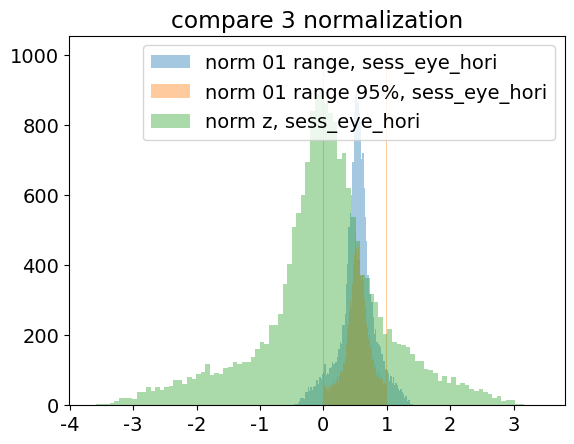

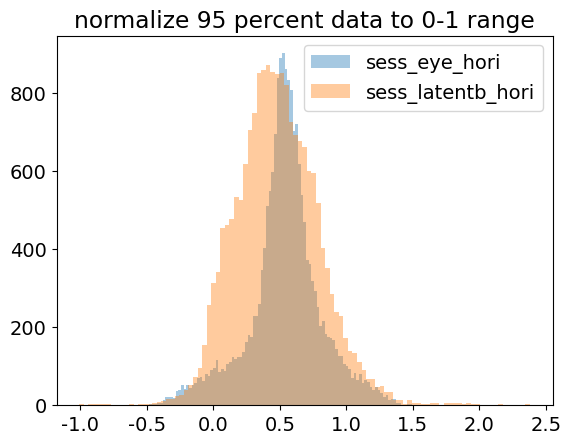

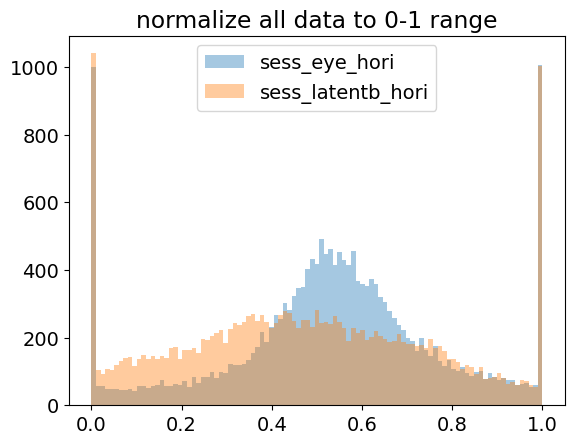

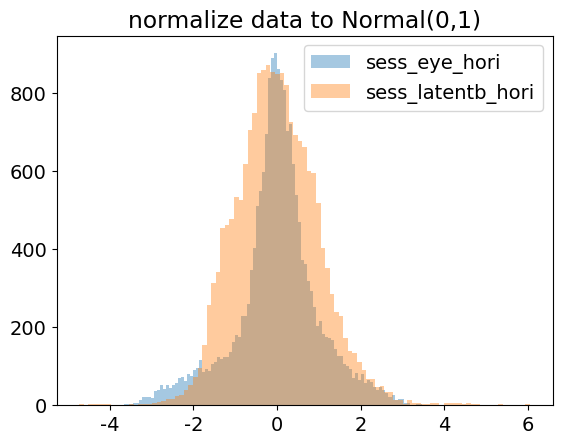

In [22]:
# def mypack(list_of_variable_names):
#     return dict((name, eval(name)) for name in list_of_variable_names)

def normalize_01(data,low=5,high=95):
    '''normalize the data vector or matrix to 0-1 range
    use percentile to avoid outliers.'''
    themin=np.percentile(data[~np.isnan(data)],low)
    themax=np.percentile(data[~np.isnan(data)],high)
    res= (data - themin) / (themax- themin)
    res[np.isnan(data)]=np.nan
    res=np.clip(res, 0,1)
    return res

def normalize_z(data):
    '''normalize the data vector or matrix to have mean of 0 std of 1'''
    nanmask=~np.isnan(data)
    validdata=data[nanmask]
    mean = sum(data[nanmask]) / len(data[nanmask])
    variance = sum((x - mean) ** 2 for x in data[nanmask]) / len(data[nanmask])
    std_deviation = variance ** 0.5
    normalized_data = [(x - mean) / std_deviation  if x else np.nan for x in data]
    return normalized_data

plt.gca().set_title('compare 3 normalization')
myhist({'norm 01 range, sess_eye_hori': normalizematrix(sess_eye_hori),
        'norm 01 range 95%, sess_eye_hori':normalize_01(sess_eye_hori),
        'norm z, sess_eye_hori':normalize_z(sess_eye_hori),
        })
plt.show()

plt.gca().set_title('normalize 95 percent data to 0-1 range')
myhist({'sess_eye_hori': normalizematrix(sess_eye_hori),
        'sess_latentb_hori':normalizematrix(sess_latentb_hori),
        })

plt.gca().set_title('normalize all data to 0-1 range')
myhist({'sess_eye_hori': normalize_01(sess_eye_hori),
        'sess_latentb_hori':normalize_01(sess_latentb_hori),
        })

plt.gca().set_title('normalize data to Normal(0,1)')
myhist({'sess_eye_hori': normalize_z(sess_eye_hori),
        'sess_latentb_hori':normalize_z(sess_latentb_hori),
        })


normalization matters. we dont want wrong normalization bias our following analysis.

eg, if two data with the same mean but different scale, the difference of the two data will be constant. we may falsely conclude the difference is important even though the two data are linearly dependent.

eg, if two data with different mean (any possible reasons?), we may not want to center them in the same mean. 

here we have eye and state/belief firefly with slightly different mean. why is that? i think we should assume they have mean of zero. because on average, mk should look straight ahead. and on average, the firefly is stright ahead. maybe due to some preferance in control, the state/belief firefly is slightly more on one direction. do we want to remove this effect in our analysis? what could be the consequence if we do?

because we shift the mean, we shift their difference=0 marker. but we are insterested in the difference as a whole, not just diff=0. so this does not matter too much. lets see an example. if we have x1 and x2, x2=x1+1. we have a constant difference. if there are some constant neurons pattern, they will be falsely marked as encoding this difference. but this is trival, and would not show in our analysis.

howver what to consider when deciding the scale (what are the outliers) is still a question. here we just treat data as normal. they are near normal but not quite. idk if that will greatly bias our anlysis or not. 

we should do the selection. 

## selection


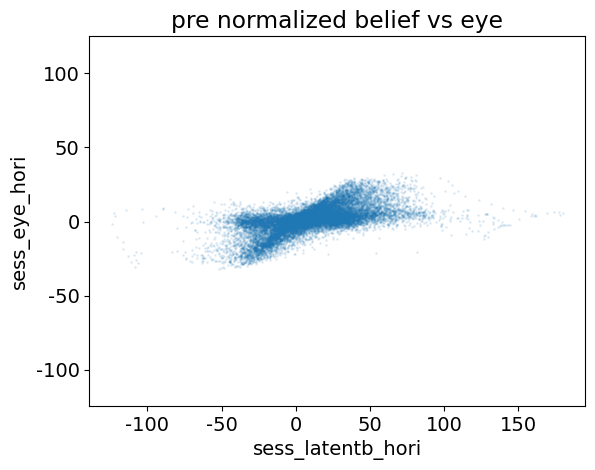

Text(0.5, 1.0, 'normalized belief vs eye')

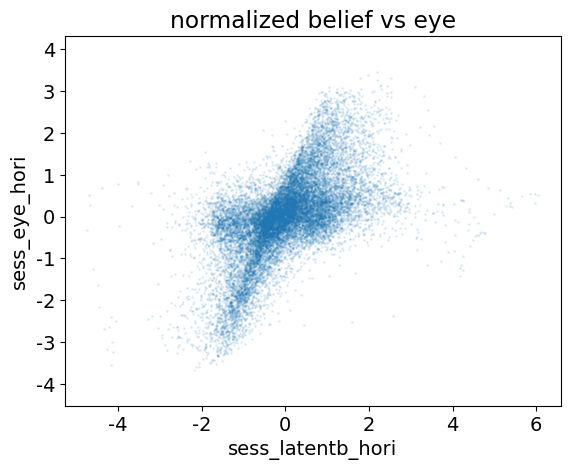

In [23]:
plt.scatter((sess_latentb_hori), (sess_eye_hori),s=1, alpha=0.1)
plt.xlabel('sess_latentb_hori')
plt.ylabel('sess_eye_hori')
plt.axis('equal')
plt.title('pre normalized belief vs eye')
plt.show()

plt.scatter(normalize_z(sess_latentb_hori), normalize_z(sess_eye_hori), s=1, alpha=0.1)
plt.xlabel('sess_latentb_hori')
plt.ylabel('sess_eye_hori')
plt.axis('equal')
plt.title('normalized belief vs eye')

(-5.272649410029059, 6.587174205221902, -4.013878989231502, 3.80922227189028)

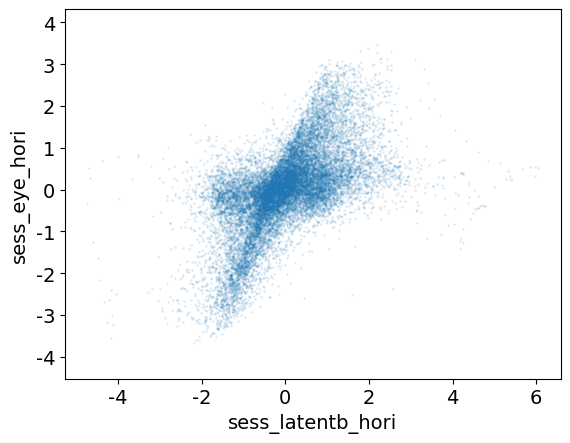

In [24]:
x,y=np.array(normalize_z(sess_latentb_hori)), np.array(normalize_z(sess_eye_hori))
mask=(x-y)**2>0
plt.scatter(x[mask],y[mask], s=1, alpha=0.1)
plt.xlabel('sess_latentb_hori')
plt.ylabel('sess_eye_hori')
plt.axis('equal')

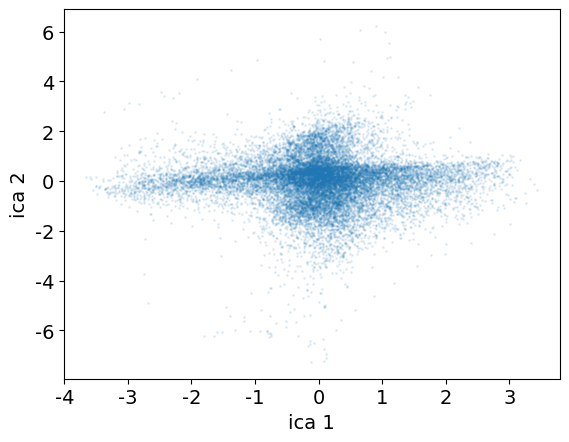

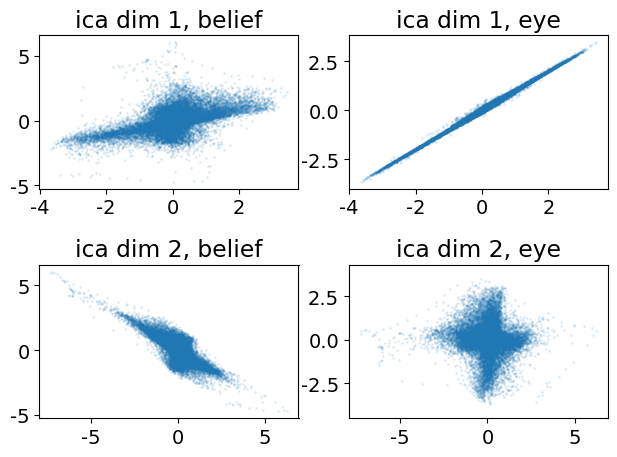

In [25]:
ica = FastICA(n_components=2)
icaX=np.vstack([x[mask],y[mask]]).T
icaS = ica.fit_transform(icaX) 
plt.scatter(icaS[:,0], icaS[:,1], s=1, alpha=0.1)
plt.xlabel('ica 1')
plt.ylabel('ica 2')
plt.show()

varname=['belief', 'eye']
fig, axs = plt.subplots(2,2)
for i in range(2):
    for j in range(2):
        ax=axs[i,j]
        ax.scatter(icaS[:,i],icaX[:,j], s=1, alpha=0.1)
        plt.axis('equal')
        ax.set_title(f'ica dim {i+1}, {varname[j]}')
plt.tight_layout()


this plot shows we shoudl do some selection. eg, if we select the middle part, uncorrected data, that could show us some different thing.



## test data visualization

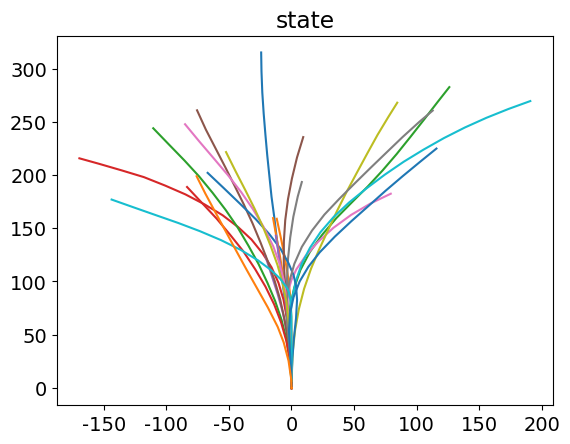

Text(0.5, 1.0, 'belief')

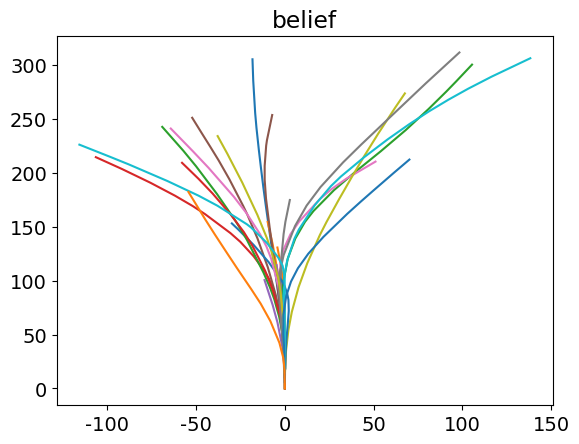

In [26]:
# sanity check. belief path should be similar to state path.
for itrial in range(22):
    (rel_dist, rel_ang, abs_dist, abs_ang,
                                    eye_hor_theta, eye_ver_theta, latent_ff_hori, latent_ff_vert,
                                    fx, fy, mx, my, mv, mw)=zip(*yy[itrial])
    plt.plot(mx, my)

    # plt.plot(np.arctan2(my,mx))
plt.title('state')
plt.show()
for ep_beliefs, ep_covs, task in zip(beliefs[:22], covs[:22], tasks[:22]):
    mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
    fx,fy=task[0]*worldscale, task[1]*worldscale
    mx, my = np.asarray(my).reshape(-1).astype('float')*worldscale, np.asarray(mx).reshape(-1).astype('float')*worldscale
    plt.plot(mx, my)
    # plt.plot(np.arctan2(my,mx))
plt.title('belief')

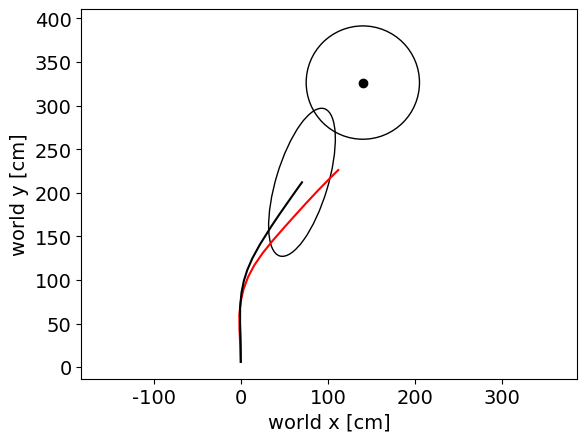

In [27]:
# plot state and belief together, visualize the belief cov and state stop

fig, ax=plt.subplots(1,1)
# for itrial in range(len(trial_idces)):
itrial-=1

# # y downsample states
# (rel_dist, rel_ang, abs_dist, abs_ang,
#                                 eye_hor_theta, eye_ver_theta, latent_ff_hori, latent_ff_vert,
#                                 fx, fy, mx, my, mv, mw)=zip(*yy[itrial])
# ep_err=distance((fx[-1]-mx[-1]),(fy[-1]-my[-1]))
# plt.plot( np.array(mx), my ,'g')

# pre irc states
ep_states=states[itrial]
mx, my, body_theta,  mv,mw= zip(*ep_states)
fx,fy=task[0]*worldscale, task[1]*worldscale
mx, my = np.asarray(my).reshape(-1).astype('float')*worldscale, np.asarray(mx).reshape(-1).astype('float')*worldscale
plt.plot( mx, my ,'r')

# belief path
ep_beliefs, ep_covs, task=beliefs[itrial], covs[itrial], tasks[itrial]
mx, my, body_theta,  mv,mw= zip(*ep_beliefs)
fx,fy=task[0]*worldscale, task[1]*worldscale
mx, my = np.asarray(my).reshape(-1).astype('float')*worldscale, np.asarray(mx).reshape(-1).astype('float')*worldscale
plt.plot( mx, my ,'k')

# belief cov
cov=ep_covs[-1]
cov=cov[:2,:2]*worldscale*worldscale
flippedcov=np.array([[cov[1,1], cov[1,0]],[cov[0,1], cov[0,0]]]) # need to flip x and y 
plot_cov_ellipse(flippedcov, [mx[-1], my[-1]], alpha=1, nstd=3,edgecolor='black',  ax=ax)


# task
from matplotlib import patches
plt.scatter(fy,fx, color='k')
circle = patches.Circle((fy,fx), 65, fill=False)
plt.gca().add_patch(circle)
plt.xlabel('world x [cm]')
plt.ylabel('world y [cm]')
plt.axis('equal')
plt.show()


# save data for cebra

In [28]:
icaS.shape, sess_t.shape

((18985, 2), (18985,))

In [29]:
# make data for auto encoder
mask=np.ones_like(sess_t).astype('bool')
thisx=r_ppc_t[mask]
thisb=np.rad2deg(belief_heading)[mask]
thise=-sess_eye_hori[mask]
thisy=[
    sess_latentff_hori, # has nan
    sess_latentff_vert, # has nan
    sess_eye_hori, # eye
    sess_eye_vert,
    sess_latentb_hori,
    sess_latentb_vert,
    sess_angle_from_start,
    sess_ll_t,
    sess_t,
    sess_err,
    sess_err_belief,
    sess_angle_from_start_belief,
    np.rad2deg(belief_heading), # belief heading
    icaS[:,0], # ica 1
    icaS[:,1], # ica 2
]
thisy=[normalize_z(y) for y in thisy]
thisy=np.vstack(thisy).T[mask]

thisyname=[
    'sess_latentff_hori',
    'sess_latentff_vert',
    'sess_eye_hori',
    'sess_eye_vert',
    'sess_latentb_hori',
    'sess_latentb_vert',
    '(sess_angle_from_start)',
    'sess_ll_t',
    'sess_t',
    'sess_err',
    'sess_err_belief',
    'sess_angle_from_start_belief',
    'belief_heading', 
    'ica belief eye 1',
    'ica belief eye 2',
]

# process the data
# outlier control
# 1, cliping
# thisy=np.clip(thisy,-4,4)
# 2, remove
thisy[(thisy < -4) | (thisy > 4)] = np.nan

# remove nan.
thisy[np.isnan(thisy)]=0 # sometime eye tracking is lost
print(thisx.shape, thisy.shape)
print(np.sum(np.isnan(thisx)),np.sum(np.isnan(thisy)))



(18985, 94) (18985, 15)
0 0


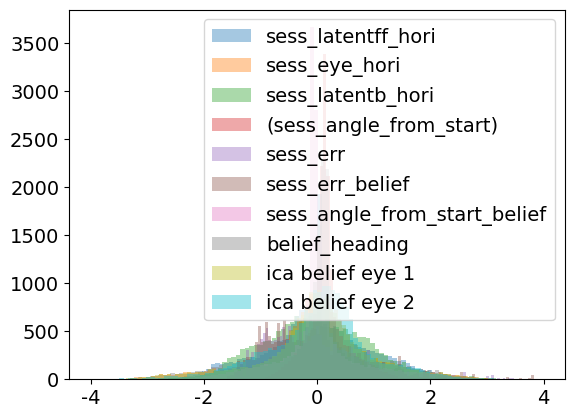

In [30]:
def myhist(data, bins=99,alpha=0.4):
    for k,v in data.items():
        plt.hist(v, bins=bins,alpha=alpha, label=k)
    plt.legend()
    plt.show()

data={}
for i in [0,2,4,6,9,10,11,12, 13, 14]:
    data[thisyname[i]]=thisy[:,i]
myhist(data)

In [31]:

# with open(f'{workdir}/test/neural/cebra/0404normzica.nbedata','wb+') as f:
#     pickle.dump((thisx, thisy,thisyname),f)

## 